In [1]:
import numpy as np
from IPython.display import display, Image
import imageio
import matplotlib.pyplot as plt
import os
from os import PathLike
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
from tqdm.notebook import tqdm  # progress bar
from typing import List, Tuple
from distutils.util import strtobool



# seed the random number generators
# https://pytorch.org/docs/stable/notes/randomness.html
def manual_seed(seed: int):

    np.random.seed(seed)
    torch.manual_seed(seed)



/tmp/ipykernel_947583/3907235755.py:16: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.util import strtobool


Defining class to obtain the dataset

In [2]:
class CNNDataset(Dataset):


    def __init__(self, dataset_path: PathLike, transform=None):

        self.dataset_path = Path(dataset_path)
        self.transform = transform

        # determine the total dataset length
        i = 0
        while (self.dataset_path / f"image{i}.npz").exists():
            i += 1
        self.len = i

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        image = np.array(np.load(self.dataset_path / f"image{idx}.npz")['image'])

        if self.transform:
            image = self.transform(image)
            # print("Image shape after transformation:", np.shape(x))  # Debugging

        label = np.load(self.dataset_path / f"label{idx}.npz")['label']
                
        return image, label

    def __len__(self) -> int:
        """
        Returns the total number of samples available in the dataset.

        Returns:
            self.len: The total number of images (or samples) in the dataset.
        """
        return self.len

Define Image transormation

In [3]:
IMAGE_TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.CenterCrop(240),
        transforms.Resize((24, 24)),
        #transforms.Normalize((0.5,), (0.5,)) ,
    ]
)

In [4]:
# Define path of dataset
DATASET_DIR = Path("dataset") 
# create the directory for well-trained neural network models
STATEDICTS_DIR = Path("statedicts")
STATEDICTS_DIR.mkdir(parents=True, exist_ok=True)



Get a visual example of transformed image

Image shape torch.Size([3, 24, 24])


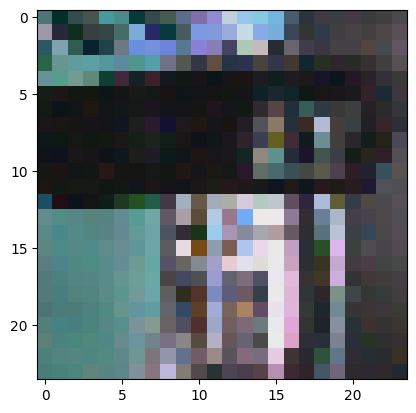

0


In [5]:
def visualize_dataset_sample(dataset_path: str, sample_idx: int = 2) -> None:
    """
    Displays a visual representation of an example image from the dataset.

    Args:
        dataset_path: Path to the directory where the dataset is stored.
        sample_idx: The index of the sample to be visualized. Defaults to 1200.

    Returns:
        None: This function only displays an image and does not return any value.
    """
    dataset = CNNDataset(dataset_path, transform=IMAGE_TRANSFORM)
    img_example,label_data_example = dataset[sample_idx]
    print('Image shape',np.shape(img_example))
    img_example = img_example.permute(1, 2, 0)
    plt.imshow(img_example, cmap="gray")
    plt.show()
    print(label_data_example)
   

visualize_dataset_sample(DATASET_DIR)

In [6]:
def load_dataloaders(
    dataset_path: PathLike,
    val_ratio: float = 0.2,
    test_ratio: float = 0.2,
    batch_size: int = 32,
) -> Tuple[DataLoader, DataLoader]:
    """
    Loads and returns data loaders for training, validation, and testing datasets.

    Args:
        dataset_path: Path to the directory where the dataset is stored.
        val_ratio: The ratio of the dataset to be used for validation.
                    It must be between 0 and 1. Defaults to 0.2.
        test_ratio: The ratio of the dataset to be used for testing.
                    It must be between 0 and 1. Defaults to 0.3.
        batch_size: The number of samples per batch to load. Defaults to 32.

    Returns:
        train_dataloader: The DataLoader instances for the training.
        val_dataloader: The DataLoader instances for the validation.
        test_dataloader: The DataLoader instances for the testing.

    Raises:
        AssertionError: If the sum of val_ratio and test_ratio is larger than 1.0
    """
    assert (
        0.0 <= val_ratio <= 1.0
    ), "Validation ratio needs to be in the interval [0, 1]."
    assert 0.0 <= test_ratio <= 1.0, "Test ratio needs to be in the interval [0, 1]."
    assert (
        val_ratio + test_ratio
    ) <= 1.0, "The sum of val and test ratio needs to be in the interval [0, 1]."


    dataset = CNNDataset(dataset_path, transform=IMAGE_TRANSFORM)
    print(f"The dataset contains {len(dataset)} samples")

    train_size = int(len(dataset) * (1.0 - val_ratio - test_ratio)) +1
    val_size = int(len(dataset) * val_ratio)
    test_size = int(len(dataset) * test_ratio)
    # print(train_size,val_size,test_size)

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader


train_loader, val_loader, test_loader = load_dataloaders(DATASET_DIR)

The dataset contains 1986 samples


In [14]:
loss_fn = nn.BCEWithLogitsLoss()

def evaluate_model(
    model: nn.Module, eval_loader: DataLoader, 
) -> Tuple[float]:
    """
    Evaluates the performance of a theta model on a test dataset.

    Args:
        model: The neural network model to be evaluated.
        eval_loader: The DataLoader for the evaluation dataset.

    """
    running_loss = 0.0

    count = 0.0
    with torch.no_grad():
        for i, (image, label) in enumerate(eval_loader):
            # Calculate loss here by calling the loss function
            pred = model(image).squeeze()
            batch_loss = loss_fn(pred,label.float())
            running_loss += batch_loss.item()
            count += 1

    loss = running_loss / count


    return loss

In [8]:
"""TASK 1b.1.1: CREATE THETA MODEL HERE"""

class CNNObstacleDetect(nn.Module):
    def __init__(self,):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3,32,3)    # 32x22x22
        self.relu1 = torch.nn.ReLU()
        self.avgPool1 = torch.nn.AvgPool2d(2)   # 32x11x11
        self.conv2 = torch.nn.Conv2d(32,10,3)     # 10x9x9
        self.relu2 = torch.nn.ReLU()
        self.avgPool2 = torch.nn.AvgPool2d(2)   # 10x4x4
        self.flat1 = torch.nn.Flatten()         # 160
        self.fc1 = torch.nn.Linear(160,30)
        self.relu3 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(30,1)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgPool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgPool2(x)
        x = self.flat1(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x
        
"""TASK 1b.1.1: END"""

model_CNN = CNNObstacleDetect()
total_params_theta = sum(p.numel() for p in model_CNN.parameters())
print("Total number of trainable model parameters: ", total_params_theta)
 

Total number of trainable model parameters:  8647


In [18]:
# set the number of runs (i.e., different random seeds)
num_runs = 1  # Change to 1 until you get it to work once (need to be 3)
# number of epochs we train each model for
num_epochs = 100

In [19]:

for run in range(num_runs):
    print(f"Starting run {run}")
    # set new random seed
    manual_seed(seed=run)
    # this code reinitializes the parameters of the model on each loop
    model_CNN = CNNObstacleDetect()

    # define the optimizer
    optimizer = torch.optim.SGD(model_CNN.parameters(), lr=0.5e-2)

    # YOUR CODE HERE
    for epoch in tqdm(range(num_epochs)):
        for image,label in train_loader:
            preds = model_CNN(image)

            batch_size = preds.shape[0]
            label_len = preds.shape[1]
            label = label.view(batch_size,label_len)
        

            loss = loss_fn(preds,label.float())
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    
    run_test_loss = evaluate_model(
        model_CNN,test_loader,
    )
    print(
        f"Run {run} finished with a test loss of {run_test_loss:.4}"
    )

    # save the model
    torch.save(
        model_CNN.state_dict(),
        STATEDICTS_DIR / f"obstacle_danger_model-{run}.pth",
        _use_new_zipfile_serialization=False,
    )


Starting run 0


  0%|          | 0/100 [00:00<?, ?it/s]

Run 0 finished with a test loss of 0.4575


In [20]:
# evaluate the theta model on the test set
test_error_across_runs_theta = np.zeros((num_runs,))
for run in range(num_runs):
    model_CNN.load_state_dict(
        torch.load(STATEDICTS_DIR / f"obstacle_danger_model-{run}.pth")
    )
    run_test_loss, run_test_error = evaluate_model(
        model_CNN, test_loader,
    )
    test_error_across_runs[run] = run_test_error
print(
    f"Prediction error of theta model across runs: {np.mean(test_error_across_runs):.4} += {np.std(test_error_across_runs):.4} rad."
)

TypeError: cannot unpack non-iterable float object